In [1]:
# Make a better system naming things, with doucmentation
import pandas as pd
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
notebook_dir = os.path.abspath(os.getcwd())
src_path = os.path.join('/home/lerceg/LukaPosao/market_models/', 'src')
sys.path.append(src_path)

import market_models.src.models.predict_model as pmx
import market_models.src.models.train_model as tm
import market_models.src.utils as utils

In [2]:
service = 'netrisk_casco'
dates = '2023_11_14__2023_11_20__2023_12_12__2023_12_22__2023_12_28__2023_12_29__2024_01_02'.split('__')
cur = ''
dates_pref = []

for i in range(1, len(dates)):
    dates_pref.append("__".join(dates[ : i + 1]))


In [3]:
dates_pref

['2023_11_14__2023_11_20',
 '2023_11_14__2023_11_20__2023_12_12',
 '2023_11_14__2023_11_20__2023_12_12__2023_12_22',
 '2023_11_14__2023_11_20__2023_12_12__2023_12_22__2023_12_28',
 '2023_11_14__2023_11_20__2023_12_12__2023_12_22__2023_12_28__2023_12_29',
 '2023_11_14__2023_11_20__2023_12_12__2023_12_22__2023_12_28__2023_12_29__2024_01_02']

In [14]:
service = 'netrisk_casco'
data_name_benchmark = 'netrisk_casco_benchmark_v1'
target_variable = 'KÖBE_price'

dates_pref = []
data_names = [f'{service}_{date}' for date in dates_pref]
data_names += ['netrisk_casco_v2', 'netrisk_casco_v5' ,'netrisk_casco_v6']
data_names += ['netrisk_casco_v10']
model_names = [utils.get_model_name(data_name, target_variable) for data_name in data_names]

data_path_benchmark = utils.get_processed_data_path(data_name_benchmark)
features_path_benchmark = utils.get_features_path(data_name_benchmark)
model_paths = [utils.get_model_path(model_name) for model_name in model_names]


data_benchmark, features = utils.load_data(data_path_benchmark, features_path_benchmark, target_variable)

print(data_benchmark.head())

models = [None] * len(model_paths)
for i in range(len(model_paths)):
    model = None
    try:
        model = utils.load_model(model_paths[i])
    except Exception as e:
        print(model_paths[i])
        data, features = utils.load_data(utils.get_processed_data_path(data_names[i]), utils.get_features_path(data_names[i]), target_variable)
        tm.train_model_util(data, features, target_variable, is_classification = False)
        model = utils.load_model(model_paths[i])
    models[i] = model
        
models = [utils.load_model(model_path) for model_path in model_paths]

predictions = [utils.predict(model, data_benchmark[features]) for model in models]

errors = [mean_absolute_error(prediction, data_benchmark[target_variable]) for prediction in predictions]

target_error = data_benchmark[target_variable].mean() * 0.03

780
  DateCrawled  isRecent  CarMake  CarAge   ccm  kw    kg  car_value  \
0  2024_01_04      True       20       2   999  74  1180    14534.0   
1  2024_01_04      True       20       4   999  92  1322    22295.0   
2  2024_01_04      True       28       1   998  49   899    14687.4   
3  2024_01_04      True       21       4  1318  75  1093    11541.4   
4  2024_01_04      True       52       5   898  66  1082     9747.4   

   CarMakerCategory  PostalCode  PostalCode2  PostalCode3  Category  \
0               1.0        7391           73          739         2   
1               1.0        1038           10          103         2   
2               1.0        7762           77          776         3   
3               1.0        5630           56          563         1   
4               1.0        8447           84          844         7   

   Longitude  Latitude  Age  LicenseAge  BonusMalus  BonusMalusCode  \
0    18.0809   46.1993   52          18         0.0               1   


In [15]:
data_benchmark

,DateCrawled,isRecent,CarMake,CarAge,ccm,kw,kg,car_value,CarMakerCategory,PostalCode,PostalCode2,PostalCode3,Category,Longitude,Latitude,Age,LicenseAge,BonusMalus,BonusMalusCode,KÖBE_price
0,2024_01_04,True,20,2,999,74,1180,14534.000,1.00,7391,73,739,2,18.0809,46.1993,52,18,0.0,1,74664.0
1,2024_01_04,True,20,4,999,92,1322,22295.000,1.00,1038,10,103,2,19.0404,47.4984,58,18,0.0,1,110166.0
2,2024_01_04,True,28,1,998,49,899,14687.400,1.00,7762,77,776,3,18.2734,46.0111,49,18,0.0,1,63318.0
3,2024_01_04,True,21,4,1318,75,1093,11541.400,1.00,5630,56,563,1,21.1333,46.7667,34,18,0.0,1,90036.0
4,2024_01_04,True,52,5,898,66,1082,9747.400,1.00,8447,84,844,7,17.5589,47.1020,61,18,1.0,2,68808.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
788,2024_01_04,True,47,10,999,85,1081,13195.000,1.00,8137,81,813,7,18.2935,46.8259,85,18,0.0,1,67344.0
789,2024_01_04,True,56,5,999,70,1165,19770.504,1.00,2740,27,274,6,20.0048,47.1899,56,18,0.0,1,72102.0
790,2024_01_04,True,23,3,998,49,996,8447.400,0.97,8735,87,873,5,17.2723,46.5387,49,18,0.0,1,63318.0
791,2024_01_04,True,28,4,998,49,899,13777.400,1.00,7471,74,747,4,17.9091,46.4245,32,18,2.0,3,72102.0


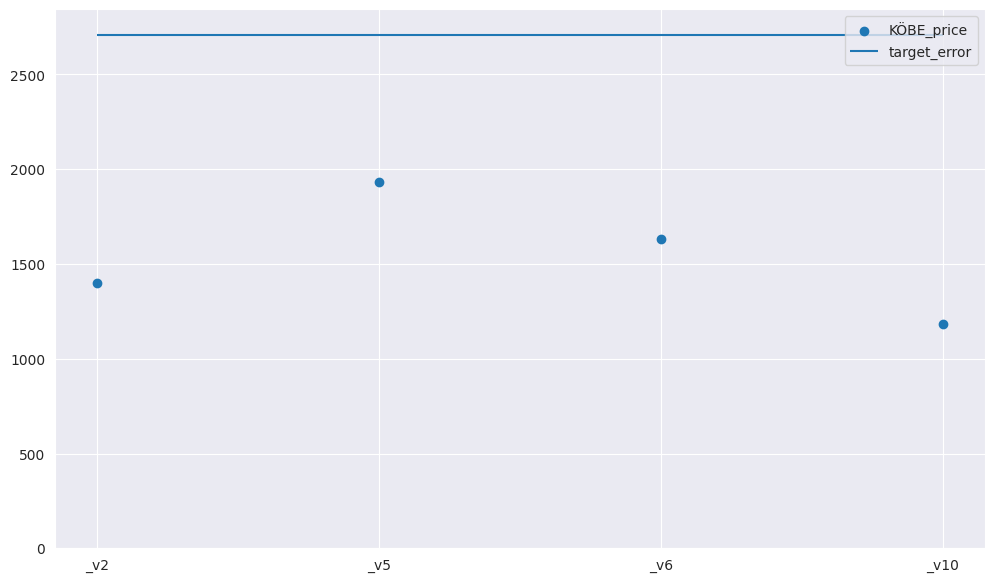

In [16]:
plt.figure(figsize = (12, 7))
x_labels = [c.replace(service, '').split('__')[-1] for c in data_names]
plt.scatter(x_labels, errors, label = target_variable)
top = max(target_error, max(errors))  * 1.05
plt.ylim(bottom = 0, top = top)
plt.hlines(y = data_benchmark[target_variable].mean() * 0.03, xmin = x_labels[0], xmax = x_labels[-1], label = 'target_error')
plt.legend()
plt.show()

In [8]:
np.array(errors) / data_benchmark[target_variable].mean() * 100

array([6.94998462])

In [30]:
data_benchmark[target_variable].mean() * 0.03

4199.426121372031

In [32]:
data, features = utils.load_data(utils.get_processed_data_path("netrisk_casco_v3"), utils.get_features_path("netrisk_casco_v3"), target_variable = target_variable)

In [38]:
data[target_variable].nunique()

379

In [16]:
def plotHistErrorPercenage(error : np.array) -> None:
    plt.hist(error, range = [error.min() - 1, error.max() + 1], bins=40,
             weights=np.ones(len(error)) / len(error))
    plt.xlabel('Error percentage')
    plt.ylabel('Percent of errors')
    plt.show()


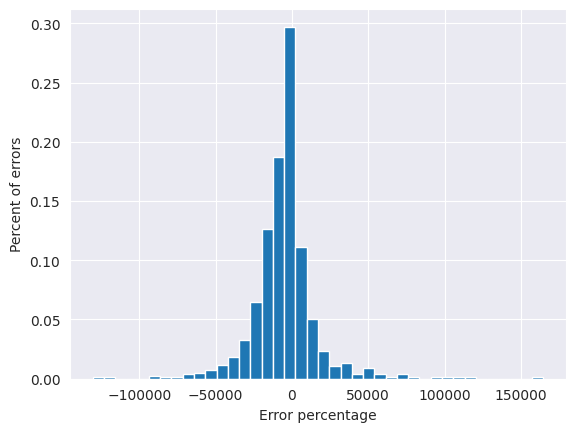

In [18]:
plotHistErrorPercenage(data_benchmark[target_variable] - predictions[-1])

In [ ]:
percentage_error.quantile([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99, 1])

In [ ]:
data[target_variable]

In [ ]:
data[data[target_variable] == 54900]

In [ ]:
data[(data['BonusMalus'] == 0) & (data['Age'].between(30, 40)) & (data['PostalCode'] < 2000)][['car_value', target_variable]].plot(kind = 'scatter', x = 'car_value', y = target_variable)

In [ ]:
data.plot(kind = 'scatter', x = 'car_value', y = target_variable)

In [ ]:
data.groupby(['car_value', 'Category', 'Age'])[target_variable].agg([('range', np.ptp), ('count', 'count'), ('min', 'min'), ('max', 'max'), ('minidx', 'idxmin'), ('maxidx', 'idxmax')])

In [ ]:
data.loc[[2923,2469]]

In [ ]:
1141680.0 / 574200.0


In [ ]:
gb_res = data.groupby(['Category', 'Age', 'kw', 'ccm', 'BonusMalus'])['car_value'].agg([('car_value_range', np.ptp), ('count', 'count'), ('idxmin', 'idxmin'), ('idxmax', 'idxmax')])

In [ ]:
def check(row):
    if row['idxmin'] == row['idxmax']:
        return 10
    try:
        min_row = data.loc[row['idxmin']]
        max_row = data.loc[row['idxmax']]
    
        price_ratio = max_row[target_variable] / min_row[target_variable]
        car_value_ratio = max_row['car_value'] / min_row['car_value']
        return abs(price_ratio - car_value_ratio)
    except Exception as e:
        return 100

In [ ]:
gb_res.apply(lambda x : check(x), axis = 1)

In [69]:
gb_res[gb_res['Catgory'] == 2]

KeyError: 'Catgory'